In [24]:
import numpy as np
import cvxpy as cp
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.special import gamma
import itertools
import time
import mosek
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
import pandas as pd

In [ ]:
def plot_eval(df, quantiles, df1=None, quantiles1=None, dro = False,end_ind=61,j=(0,0,0), q = (40,60),K=5, alpha=0.1):
    j1,j2,j3 = j
    # Set up LaTeX rendering
    df = df[K]
    # df = quantiles[K][50].copy()
    # df1 = quantiles[0][50].copy()
    quantiles = quantiles[K].copy()
    fontsize = 10
    q1,q2 = q
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "font.size": fontsize,
        "axes.labelsize": fontsize,
        "axes.titlesize": fontsize,
        "legend.fontsize": 8
    })
    t_range = np.array(df['t'])[(0*end_ind):(1)*end_ind:2]
    plt.figure(figsize=(4, 2), dpi=300)
    plt.plot(t_range, df['O_eval0'][(j1*end_ind):(j1+1)*end_ind:2], 'b-', linewidth=1, label = "online clustering", marker="v",ms=1.5)

    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['O_eval0'][(j1*end_ind):(j1+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['O_eval0'][(j1*end_ind):(j1+1)*end_ind:2]).astype(float),alpha=alpha, color = 'b')
    plt.plot(t_range, df['MRO_eval0'][(j2*end_ind):(j2+1)*end_ind:2], 'r-', linewidth=1, label = "reclustering", marker="D",ms=1.5)
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['MRO_eval0'][(j2*end_ind):(j2+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['MRO_eval0'][(j2*end_ind):(j2+1)*end_ind:2]).astype(float),alpha=alpha, color='r')

    plt.plot(t_range, df1['SA_eval1'][(j3*end_ind):(j3+1)*end_ind-1:2], 'g-', linewidth=1, label = "SAA", marker="o",ms=1.5)
    plt.plot(t_range, df1['DRO_eval1'][(j3*end_ind):(j3+1)*end_ind-1:2], color ='black', linewidth=1, label = "DRO", marker="s",ms=1.5)
    plt.fill_between(np.array(t_range),y1=np.array(quantiles1[q1]['SA_eval1'][(j3*end_ind):(j3+1)*end_ind:2]).astype(float),y2=np.array(quantiles1[q2]['SA_eval1'][(j3*end_ind):(j3+1)*end_ind:2]).astype(float),alpha=alpha, color='g')
    plt.fill_between(np.array(t_range),y1=np.array(quantiles1[q1]['DRO_eval1'][(j3*end_ind):(j3+1)*end_ind:2]).astype(float),y2=np.array(quantiles1[q2]['DRO_eval1'][(j3*end_ind):(j3+1)*end_ind:2]).astype(float),alpha=alpha, color='black')

    plt.ylim([0.008,0.022])
    plt.legend()
    plt.xlabel(r'Time step $(t)$')
    plt.title(r'Out-of-sample expected value')
    plt.grid(True, alpha=0.3)
    plt.savefig('eval_analysis.pdf', bbox_inches='tight', dpi=300)

    plt.figure(figsize=(4, 2), dpi=300)
    plt.plot(t_range, df['obj_values'][(j1*end_ind):(j1+1)*end_ind-1:2], 'b-', linewidth=1, label = "online clustering", marker="v",ms=1.5)
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['obj_values'][(j1*end_ind):(j1+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['obj_values'][(j1*end_ind):(j1+1)*end_ind:2]).astype(float),alpha=alpha, color = 'b')
    plt.plot(t_range, df['MRO_obj_values'][(j2*end_ind):(j2+1)*end_ind-1:2], 'r-', linewidth=1, label = "reclustering", marker="D",ms=1.5)
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['MRO_obj_values'][(j2*end_ind):(j2+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['MRO_obj_values'][(j2*end_ind):(j2+1)*end_ind:2]).astype(float),alpha=alpha, color='r')
    # plt.plot(t_range, df['worst_values'][(j2*end_ind):(j2+1)*end_ind-1:2], 'b-.', linewidth=1, label = r"online clustering $\hat{H}^K_t$")
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['MRO_worst_values'][(j2*end_ind):(j2+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['MRO_worst_values'][(j2*end_ind):(j2+1)*end_ind:2]).astype(float),alpha=alpha, color='r')
    plt.plot(t_range, df['MRO_worst_values'][(j2*end_ind):(j2+1)*end_ind-1:2], 'r:', linewidth=1, label = r"reclustering $\hat{H}^K_t$", marker="^",ms=1.5)
    # plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['worst_values'][(j2*end_ind):(j2+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['worst_values'][(j2*end_ind):(j2+1)*end_ind:2]).astype(float),alpha=alpha, color = 'b')
    plt.plot(t_range, df1['SA_obj_values'][(j3*end_ind):(j3+1)*end_ind-1:2], 'g-', linewidth=1, label = "SAA", marker="o",ms=1.5)
    plt.plot(t_range, df1['DRO_obj_values'][(j3*end_ind):(j3+1)*end_ind-1:2], color ='black', linewidth=1, label = "DRO", marker="s",ms=1.5)
    plt.fill_between(np.array(t_range),y1=np.array(quantiles1[q1]['DRO_obj_values'][(j3*end_ind):(j3+1)*end_ind:2]).astype(float),y2=np.array(quantiles1[q2]['DRO_obj_values'][(j3*end_ind):(j3+1)*end_ind:2]).astype(float),alpha=alpha, color = 'black')
    plt.fill_between(np.array(t_range),y1=np.array(quantiles1[q1]['SA_obj_values'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float),y2=np.array(quantiles1[q2]['SA_obj_values'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float),alpha=alpha, color = 'g')

    plt.legend()
    plt.xlabel(r'Time step $(t)$')
    plt.title(r'In-sample objective value')
    plt.ylim([0.008,0.022])
    plt.grid(True, alpha=0.3)
    plt.savefig('obj_analysis.pdf', bbox_inches='tight', dpi=300)


In [ ]:
def plot_eval_all(df, quantiles, df1=None, quantiles1=None,end_ind=61,j=(0,0,0), q = (40,60),K=5, alpha=0.1,ylim = [0.008,0.022], legend = True,val2 = 3, end_ind1 = 61):
    j1,j2,j3 = j
    # Set up LaTeX rendering
    df = df[K].copy()
    fontsize= 10
    # df = df[K]
    # df = quantiles[K][50].copy()
    # df1 = quantiles[0][50].copy()
    quantiles = quantiles[K].copy()
    q1,q2 = q
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "font.size": 10,
        "axes.labelsize": 10,
        "axes.titlesize": 11,
        "legend.fontsize": 11
    })
    t_range = np.array(df['t'])[(0*end_ind):(1)*end_ind:2]
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(9, val2), dpi=300)
    
    # online and reclustering
    ax1.plot(t_range, df['O_eval2'][(j1*end_ind):(j1+1)*end_ind:2], 'b-', linewidth=1, label = "online clustering", marker="v",ms=1.5)

    ax1.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['O_eval2'][(j1*end_ind):(j1+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['O_eval2'][(j1*end_ind):(j1+1)*end_ind:2]).astype(float),alpha=alpha, color = 'b')
    ax1.plot(t_range, df['MRO_eval2'][(j2*end_ind):(j2+1)*end_ind:2], 'r-', linewidth=1, label = "reclustering", marker="D",ms=1.5)
    ax1.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['MRO_eval2'][(j2*end_ind):(j2+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['MRO_eval2'][(j2*end_ind):(j2+1)*end_ind:2]).astype(float),alpha=alpha, color='r')

    # DRO and SAA
    ax1.plot(t_range, df1['SA_eval3'][(j3*end_ind):(j3+1)*end_ind:2], 'g-', linewidth=1, label = "SAA", marker="o",ms=1.5)
    ax1.plot(t_range, df1['DRO_eval3'][(j3*end_ind):(j3+1)*end_ind:2], color ='black', linewidth=1, label = "DRO", marker="s",ms=1.5)
    ax1.fill_between(np.array(t_range),y1=np.array(quantiles1[q1]['SA_eval3'][(j3*end_ind):(j3+1)*end_ind:2]).astype(float),y2=np.array(quantiles1[q2]['SA_eval3'][(j3*end_ind):(j3+1)*end_ind:2]).astype(float),alpha=alpha, color='g')
    ax1.fill_between(np.array(t_range),y1=np.array(quantiles1[q1]['DRO_eval3'][(j3*end_ind):(j3+1)*end_ind:2]).astype(float),y2=np.array(quantiles1[q2]['DRO_eval3'][(j3*end_ind):(j3+1)*end_ind:2]).astype(float),alpha=alpha, color='black')

    ax1.set_ylim(ylim)
    # plt.legend()
    ax1.set_xlabel(r'Time step $(t)$')
    ax1.set_title(r'Out-of-sample expected value')
    ax1.grid(True, alpha=0.3)

    # online and reclustering
    lines1, = ax2.plot(t_range, df['obj_values'][(j1*end_ind):(j1+1)*end_ind:2], 'b-', linewidth=1, label = "online clustering", marker="v",ms=1.5)
    ax2.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['obj_values'][(j1*end_ind):(j1+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['obj_values'][(j1*end_ind):(j1+1)*end_ind:2]).astype(float),alpha=alpha, color = 'b')
    lines2, = ax2.plot(t_range, df['MRO_obj_values'][(j2*end_ind):(j2+1)*end_ind:2], 'r-', linewidth=1, label = "reclustering", marker="D",ms=1.5)
    ax2.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['MRO_obj_values'][(j2*end_ind):(j2+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['MRO_obj_values'][(j2*end_ind):(j2+1)*end_ind:2]).astype(float),alpha=alpha, color='r')

    # reclustering worst
    ax2.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['MRO_worst_values'][(j2*end_ind):(j2+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['MRO_worst_values'][(j2*end_ind):(j2+1)*end_ind:2]).astype(float),alpha=alpha, color='r')
    lines5, = ax2.plot(t_range, df['MRO_worst_values'][(j2*end_ind):(j2+1)*end_ind:2], 'r:', linewidth=1, label = r"reclustering $\hat{H}^K_t$", marker="^",ms=1.5)

    # DRO and SAA
    lines3, = ax2.plot(t_range, df1['SA_obj_values'][(j3*end_ind):(j3+1)*end_ind:2], 'g-', linewidth=1, label = "SAA", marker="o",ms=1.5)
    lines4, = ax2.plot(t_range, df1['DRO_obj_values'][(j3*end_ind):(j3+1)*end_ind:2], color ='black', linewidth=1, label = "DRO", marker="s",ms=1.5)
    ax2.fill_between(np.array(t_range),y1=np.array(quantiles1[q1]['DRO_obj_values'][(j3*end_ind):(j3+1)*end_ind:2]).astype(float),y2=np.array(quantiles1[q2]['DRO_obj_values'][(j3*end_ind):(j3+1)*end_ind:2]).astype(float),alpha=alpha, color = 'black')
    ax2.fill_between(np.array(t_range),y1=np.array(quantiles1[q1]['SA_obj_values'][(j3*end_ind):(j3+1)*end_ind:2]).astype(float),y2=np.array(quantiles1[q2]['SA_obj_values'][(j3*end_ind):(j3+1)*end_ind:2]).astype(float),alpha=alpha, color = 'g')

    ax2.set_xlabel(r'Time step $(t)$')
    ax2.set_title(r'In-sample objective value')
    ax2.set_ylim(ylim)
    ax2.grid(True, alpha=0.3)

    # online and reclustering
    ax3.plot(t_range, df['O_satisfy2'][(j1*end_ind):(j1+1)*end_ind:2], 'b-', linewidth=1, label = "online clustering", marker="v",ms=1.5)
    ax3.plot(t_range, df['MRO_satisfy2'][(j2*end_ind):(j2+1)*end_ind:2], 'r-', linewidth=1, label = "reclustering",marker="D",ms=1.5)
    # reclustering worst
    ax3.plot(t_range, df['MRO_worst_satisfy2'][(j2*end_ind):(j2+1)*end_ind:2], 'r:', linewidth=1, label = r"reclustering $\hat{H}^K_t$",marker="^",ms=1.5)
    # DRO and SAA
    plt.plot(t_range, df1['SA_satisfy3'][(j3*end_ind):(j3+1)*end_ind:2], 'g-', linewidth=1, label = "SAA",marker="o",ms=1.5)
    plt.plot(t_range, df1['DRO_satisfy3'][(j3*end_ind):(j3+1)*end_ind:2], color ='black', linewidth=1, label = "DRO",marker="s",ms=1.5)
    ax3.set_xlabel(r'Time step $(t)$')
    ax3.set_title(r'Confidence $(1-\hat{\beta}_t)$')
    ax3.grid(True, alpha=0.3)
    
    # Create a shared legend beneath the plots
    lines = [lines1, lines2, lines3, lines4,lines5]
    labels = [line.get_label() for line in lines]
    if legend:
        legend = fig.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=5)
    plt.tight_layout()
    # fig.subplots_adjust(bottom=0.05)  # Adjust the bottom margin to fit the legend
    plt.savefig('obj_analysis'+str(K)+'.pdf', bbox_inches='tight', dpi=300)


In [147]:

def plot_computation_times(df, quantiles, df1=None, quantiles1=None,end_ind=61,j=(0,0,0), q = (40,60),K=5, alpha=0.1):
    j1,j2,j3 = j
    df = df[K]
    # df = quantiles[K][50].copy()
    # df1 = quantiles[0][50].copy()
    quantiles = quantiles[K].copy()
    fontsize= 11
    q1,q2 = q
    # Set up LaTeX rendering
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "font.size": 10,       
        "axes.labelsize": 10,
        "axes.titlesize": 11,
        "legend.fontsize": 11
        
    })
    # online and reclustering
    t_range = np.array(df['t'])[(0*end_ind):(1)*end_ind]
    indices = [i for i,x in enumerate(t_range) if x % 100 == 0]
    t_range = np.array(df['t'])[(0*end_ind):(1)*end_ind][indices]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 2.5), dpi=300)
    ax1.plot(t_range, np.array(df['online_time'][(j1*end_ind):(j1+1)*end_ind])[indices], 'b-', linewidth=1, label = "online clustering", marker="v",ms=1.5)
    ax1.plot(t_range, np.array(df['MRO_time'][(j2*end_ind):(j2+1)*end_ind])[indices], 'r-', linewidth=1, label = "reclustering",marker="D",ms=1.5)
    ax1.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['online_time'][(j1*end_ind):(j1+1)*end_ind]).astype(float)[indices],y2=np.array(quantiles[q2]['online_time'][(j1*end_ind):(j1+1)*end_ind]).astype(float)[indices],alpha=alpha, color = 'b')
    ax1.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['MRO_time'][(j2*end_ind):(j2+1)*end_ind]).astype(float)[indices],y2=np.array(quantiles[q2]['MRO_time'][(j2*end_ind):(j2+1)*end_ind]).astype(float)[indices],alpha=alpha, color = 'r')

    # reclustering worst
    ax1.plot(t_range, np.array(np.array(df['MRO_worst_times'][(j1*end_ind):(j1+1)*end_ind]))[indices], 'r:', linewidth=1, label = r"reclustering $\hat{H}^K_t$", marker="^",ms=1.5)
    ax1.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['MRO_worst_times'][(j2*end_ind):(j2+1)*end_ind]).astype(float)[indices],y2=np.array(quantiles[q2]['MRO_worst_times'][(j2*end_ind):(j2+1)*end_ind]).astype(float)[indices],alpha=alpha, color = 'r')
    
    # DRO and SAA
    ax1.plot(t_range, np.array(df1['DRO_time'][(j3*end_ind):(j3+1)*end_ind])[indices], color ='black', linewidth=1, label = "DRO",marker="s",ms=1.5)
   
    ax1.plot(t_range, np.array(df1['SA_time'][(j3*end_ind):(j3+1)*end_ind])[indices], color ='g', linewidth=1, label = "SAA",marker="o",ms=1.5)
    ax1.fill_between(np.array(t_range),y1=np.array(quantiles1[q1]['DRO_time'][(j3*end_ind):(j3+1)*end_ind]).astype(float)[indices],y2=np.array(quantiles1[q2]['DRO_time'][(j3*end_ind):(j3+1)*end_ind]).astype(float)[indices],alpha=alpha, color = 'black')
    ax1.fill_between(np.array(t_range),y1=np.array(quantiles1[q1]['SA_time'][(j3*end_ind):(j3+1)*end_ind]).astype(float)[indices],y2=np.array(quantiles1[q2]['SA_time'][(j3*end_ind):(j3+1)*end_ind]).astype(float)[indices],alpha=alpha, color = 'g')

    ax1.set_xlabel(r'Time step $(t)$')
    ax1.set_title(r'Compuation time per iteration (s)')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([1e-4,1e3])
    ax1.set_yscale("log")

    mult = 100
    # online and reclustering
    # collist = ['online_time','MRO_time','MRO_worst_times']
    # collist2 = ['DRO_time',"SA_time"]
    # for col in collist:
    #     df[col] = np.array(df[col])
    #     df[col] = 50*np.array(df[col][200:])
    #     quantiles[q1][col] = np.array(quantiles[q1][col])
    #     quantiles[q2][col] = np.array(quantiles[q2][col])
    #     quantiles[q1][col][200:] = 50*np.array(quantiles[q1][col][200:])
    #     quantiles[q2][col][200:] = 50*np.array(quantiles[q2][col][200:])
    # for col in collist2:
    #     quantiles1[q1][col] = np.array(quantiles1[q1][col])
    #     quantiles1[q2][col] = np.array(quantiles1[q2][col])
    #     df1[col] = np.array(df1[col])
    #     df1[col][200:]= 50*np.array(df1[col][200:])
    #     quantiles1[q1][col][200:] = 50*np.array(quantiles1[q1][col][200:])
    #     quantiles1[q2][col][200:] = 50*np.array(quantiles1[q2][col][200:])

    lines1, = ax2.plot(t_range, mult*np.cumsum(np.array(df['online_time'][(j1*end_ind):(j1+1)*end_ind])[indices]), 'b-', linewidth=1, label = "online clustering", marker="v",ms=1.5)
    lines2, = ax2.plot(t_range, mult*np.cumsum(np.array(df['MRO_time'][(j2*end_ind):(j2+1)*end_ind])[indices]), 'r-', linewidth=1, label = "reclustering",marker="D",ms=1.5)
    ax2.fill_between(np.array(t_range),y1=mult*np.cumsum(np.array(quantiles[q1]['online_time'][(j1*end_ind):(j1+1)*end_ind]).astype(float)[indices]),y2=mult*np.cumsum(np.array(quantiles[q2]['online_time'][(j1*end_ind):(j1+1)*end_ind]).astype(float)[indices]),alpha=alpha, color = 'b')
    ax2.fill_between(np.array(t_range),y1=mult*np.cumsum((np.array(quantiles[q1]['MRO_time'][(j2*end_ind):(j2+1)*end_ind]).astype(float)[indices])),y2=mult*np.cumsum(np.array(quantiles[q2]['MRO_time'][(j2*end_ind):(j2+1)*end_ind]).astype(float)[indices]),alpha=alpha, color = 'r')

    # reclustering worst
    lines5, = ax2.plot(t_range, np.cumsum(mult*np.array(df['MRO_worst_times'][(j2*end_ind):(j2+1)*end_ind])[indices]), 'r:', linewidth=1, label = r"reclustering $\hat{H}^K_t$",marker="^",ms=1.5)
    ax2.fill_between(np.array(t_range),y1=mult*np.cumsum(np.array(quantiles[q1]['MRO_worst_times'][(j2*end_ind):(j2+1)*end_ind]).astype(float)[indices]),y2=mult*np.cumsum(np.array(quantiles[q2]['MRO_worst_times'][(j2*end_ind):(j2+1)*end_ind]).astype(float)[indices]),alpha=alpha, color = 'r')

    # DRO and SAA
    lines3, = ax2.plot(t_range, mult*np.cumsum(np.array(df1['DRO_time'][(j3*end_ind):(j3+1)*end_ind])[indices]), color ='black', linewidth=1, label = "DRO",marker="s",ms=1.5)
    lines4, = ax2.plot(t_range, mult*np.cumsum(np.array(df1['SA_time'][(j3*end_ind):(j3+1)*end_ind])[indices]), color ='g', linewidth=1, label = "SAA",marker="o",ms=1.5)
    ax2.fill_between(np.array(t_range),y1=mult*np.cumsum(np.array(quantiles1[q1]['DRO_time'][(j3*end_ind):(j3+1)*end_ind]).astype(float)[indices]),y2=mult*np.cumsum(np.array(quantiles1[q2]['DRO_time'][(j3*end_ind):(j3+1)*end_ind]).astype(float)[indices]),alpha=alpha, color = 'black')
    ax2.fill_between(np.array(t_range),y1=mult*np.cumsum(np.array(quantiles1[q1]['SA_time'][(j3*end_ind):(j3+1)*end_ind]).astype(float)[indices]),y2=mult*np.cumsum(np.array(quantiles1[q2]['SA_time'][(j3*end_ind):(j3+1)*end_ind]).astype(float)[indices]),alpha=alpha, color = 'g')

    ax2.set_xlabel(r'Time step $(t)$')
    ax2.set_title(r'Cumulative compuation time (s)')
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale("log")
    
    lines = [lines1, lines2, lines3, lines4,lines5]
    labels = [line.get_label() for line in lines]
    legend = fig.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=5)
    plt.tight_layout()

    plt.savefig('time_iters.pdf', bbox_inches='tight', dpi=300)

In [70]:
def plot_satisfy(df, df1=None,end_ind=61,j=(0,0,0),K=5):
    # Set up LaTeX rendering
    j1,j2,j3 = j
    df = df[K]
    # df = quantiles[K][50].copy()
    # df1 = quantiles[0][50].copy()
    quantiles = quantiles[K].copy()
    fontsize= 10
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "font.size": fontsize,
        "axes.labelsize": fontsize,
        "axes.titlesize": fontsize,
        "legend.fontsize": 8
    })
    t_range = df['t'][(0*end_ind):(1)*end_ind:2]
    plt.figure(figsize=(4, 2), dpi=300)

    # online and reclustering
    plt.plot(t_range, df['O_satisfy1'][(j1*end_ind):(j1+1)*end_ind:2], 'b-', linewidth=1, label = "online clustering", marker="v",ms=1.5)
    plt.plot(t_range, df['MRO_satisfy1'][(j2*end_ind):(j2+1)*end_ind:2], 'r-', linewidth=1, label = "reclustering",marker="D",ms=1.5)
    
    #reclustering worst
    plt.plot(t_range, df['MRO_worst_satisfy1'][(j2*end_ind):(j2+1)*end_ind:2], 'r:', linewidth=1, label = r"reclustering $\hat{H}^K_t$",marker="^",ms=1.5)

    # DRO and SAA
    plt.plot(t_range, df1['SA_satisfy1'][(j3*end_ind):(j3+1)*end_ind-1:2], 'g-', linewidth=1, label = "SAA",marker="o",ms=1.5)
    plt.plot(t_range, df1['DRO_satisfy1'][(j3*end_ind):(j3+1)*end_ind-1:2], color ='black', linewidth=1, label = "DRO",marker="s",ms=1.5)
    plt.legend()
    plt.xlabel(r'Time step $(t)$')
    plt.title(r'Confidence $(1-\hat{\beta}_t)$')
    plt.grid(True, alpha=0.3)
    plt.savefig('prob_analysis.pdf', bbox_inches='tight', dpi=300)


In [178]:
def plot_regret(df, quantiles, df1=None, quantiles1=None,end_ind=61,j=(0,0,0), q = (40,60),K=5, alpha=0.1):
    j1,j2,j3 = j
    # Set up LaTeX rendering
    df = df[K]
    # df = quantiles[K][50].copy()
    # df1 = quantiles[0][50].copy()
    quantiles = quantiles[K].copy()
    fontsize= 10
    q1,q2 = q
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "font.size": fontsize,
        "axes.labelsize": fontsize,
        "axes.titlesize": 11,
        "legend.fontsize": 8
    })
    plt.figure(figsize=(4.3, 2), dpi=300)

    t_range = np.array(df['t'])[(0*end_ind):(1)*end_ind]
    indices = [i for i,x in enumerate(t_range) if x % 100 == 0][:-1]
    indices2 = np.array(indices) + 1
    indices2 = list(indices2)
    indices1 = indices2
    t_range = np.array(df['t'])[(0*end_ind):(1)*end_ind][indices1]
    print(t_range.shape)
    # online and reclustering regret
    plt.plot(t_range, np.cumsum(np.array(df['worst_values_regret'][(j1*end_ind):(j1+1)*end_ind])[indices2]-np.array(df1['DRO_obj_values'][(j3*end_ind):(j3+1)*end_ind])[indices1])/(len(indices1)), 'b-', linewidth=1, label = "online clustering", marker="v",ms=1.5)
    
    plt.fill_between(np.array(t_range),
    y1= np.cumsum(np.array(quantiles[q1]['worst_values_regret'][(j1*end_ind):(j1+1)*end_ind])[indices2]-np.array(quantiles1[q1]['DRO_obj_values'][(j3*end_ind):(j3+1)*end_ind])[indices1])/(len(indices1)),
    y2=np.cumsum(np.array(quantiles[q2]['worst_values_regret'][(j1*end_ind):(j1+1)*end_ind])[indices2]-np.array(quantiles1[q2]['DRO_obj_values'][(j3*end_ind):(j3+1)*end_ind])[indices1])/(len(indices1)),alpha=alpha, color = 'b')

    plt.plot(t_range, np.cumsum(np.array(df['MRO_worst_values_regret'][(j2*end_ind):(j2+1)*end_ind])[indices2]-np.array(df1['DRO_obj_values'][(j3*end_ind):(j3+1)*end_ind])[indices1])/(len(indices1)), 'r-', linewidth=1, label = "reclustering", marker="D",ms=1.5)

    plt.fill_between(np.array(t_range),
    y1= np.cumsum(np.array(quantiles[q1]['MRO_worst_values_regret'][(j2*end_ind):(j2+1)*end_ind])[indices2]-np.array(quantiles1[q1]['DRO_obj_values'][(j3*end_ind):(j3+1)*end_ind])[indices1])/(len(indices1)),
    y2=np.cumsum(np.array(quantiles[q2]['MRO_worst_values_regret'][(j2*end_ind):(j2+1)*end_ind])[indices2]-np.array(quantiles1[q2]['DRO_obj_values'][(j3*end_ind):(j3+1)*end_ind])[indices1])/(len(indices1)),alpha=alpha, color = 'r')

    # theoretical bounds
    plt.plot(t_range, 5*np.array(df['regret_bound'][(j1*end_ind):(j1+1)*end_ind])[indices2]+ 5*np.array(df['sig_val'][(j1*end_ind):(j1+1)*end_ind])[indices2], 'b:', linewidth=1, label = "online clustering UB", marker="o",ms=1.5)
    plt.fill_between(np.array(t_range),y1=np.array(5*quantiles[q1]['regret_bound'][(j1*end_ind):(j1+1)*end_ind])[indices2]+ np.array(5*quantiles[q1]['sig_val'][(j1*end_ind):(j1+1)*end_ind])[indices2],y2=np.array(5*quantiles[q2]['regret_bound'][(j1*end_ind):(j1+1)*end_ind])[indices2]+np.array(5*quantiles[q2]['sig_val'][(j1*end_ind):(j1+1)*end_ind])[indices2],alpha=alpha, color = 'b')

    plt.plot(t_range, 5*np.array(df['MRO_regret_bound'][(j1*end_ind):(j1+1)*end_ind])[indices2]+ 5*np.array(df['MRO_sig_val'][(j1*end_ind):(j1+1)*end_ind])[indices2], 'r:', linewidth=1, label = "reclustering UB", marker="o",ms=1.5)
    plt.fill_between(np.array(t_range),y1=np.array(5*quantiles[q1]['MRO_regret_bound'][(j1*end_ind):(j1+1)*end_ind])[indices2]+ np.array(5*quantiles[q1]['MRO_sig_val'][(j1*end_ind):(j1+1)*end_ind])[indices2],y2=np.array(5*quantiles[q2]['MRO_regret_bound'][(j1*end_ind):(j1+1)*end_ind])[indices2]+np.array(5*quantiles[q2]['MRO_sig_val'][(j1*end_ind):(j1+1)*end_ind])[indices2],alpha=alpha, color = 'r')

    plt.legend(ncol = 2)
    plt.xlabel(r'Time step $(t)$')
    plt.title(r'Dynamic regret')
    # plt.ylim([0.008,0.022])
    plt.yscale('log')
    plt.grid(True, alpha=alpha)
    plt.savefig('regret_analysis.pdf', bbox_inches='tight', dpi=300)


In [180]:
def plot_bounds(df, quantiles, df1=None, quantiles1=None, end_ind=61,j=(0,0,0), q = (40,60),K=5, alpha=0.1):
    j1,j2,j3 = j
    # Set up LaTeX rendering
    df = df[K]
    # df = quantiles[K][50].copy()
    # df1 = quantiles[0][50].copy()
    quantiles = quantiles[K].copy()
    fontsize= 10
    q1,q2 = q
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "font.size": fontsize,
        "axes.labelsize": fontsize,
        "axes.titlesize": 11,
        "legend.fontsize": 8
    })
    t_range = np.array(df['t'])[(0*end_ind)+1:(1)*end_ind:2]

    plt.figure(figsize=(4.3, 2), dpi=300)

    # DRO upper
    plt.plot(t_range, np.array(df1['DRO_obj_values'][(j3*end_ind):(j3+1)*end_ind-1:2])+ 5*np.array(df['MRO_sig_val'][(j2*end_ind):(j2+1)*end_ind-1:2]), color ='purple', linewidth=1, label = r"DRO $H_t + \psi_L(K,t)$", marker="s",ms=1.5)

    plt.fill_between(np.array(t_range),y1=np.array(quantiles1[q1]['DRO_obj_values'][(j3*end_ind)+1:(j3+1)*end_ind:2])+5*np.array(quantiles[q1]['MRO_sig_val'][(j2*end_ind)+1:(j2+1)*end_ind:2]) ,y2=np.array(quantiles1[q2]['DRO_obj_values'][(j3*end_ind)+1:(j3+1)*end_ind:2])+5*np.array(quantiles[q2]['MRO_sig_val'][(j2*end_ind)+1:(j2+1)*end_ind:2]),alpha=alpha, color = 'purple')

    # reclustering upper
    plt.plot(t_range, df['MRO_obj_values'][(j2*end_ind):(j2+1)*end_ind-1:2] + 5*df['MRO_sig_val'][(j2*end_ind):(j2+1)*end_ind-1:2], 'orange', linewidth=1, label = r"reclustering $H^K_t + \psi_L(K,t)$", marker="D",ms=1.5)
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['MRO_obj_values'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float)+ 5*np.array(quantiles[q1]['MRO_sig_val'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['MRO_obj_values'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float)+5*np.array(quantiles[q2]['MRO_sig_val'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),alpha=alpha, color='orange')

    # reclustering worst
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['MRO_worst_values'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['MRO_worst_values'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),alpha=alpha, color='r')

    plt.plot(t_range, df['MRO_worst_values'][(j2*end_ind):(j2+1)*end_ind-1:2], 'r:', linewidth=1, label = r"reclustering $\hat{H}^K_t$", marker="^",ms=1.5)
    
    # DRO
    plt.plot(t_range, df1['DRO_obj_values'][(j3*end_ind):(j3+1)*end_ind-1:2], color ='black', linewidth=1, label = r"DRO $H_t$", marker="s",ms=1.5)
    plt.fill_between(np.array(t_range),y1=np.array(quantiles1[q1]['DRO_obj_values'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float),y2=np.array(quantiles1[q2]['DRO_obj_values'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float),alpha=alpha, color = 'black')
    
    plt.legend(loc = 'lower right', ncol = 2)
    plt.xlabel(r'Time step $(t)$')
    plt.title(r'In-sample values and bounds, $\varepsilon_t = 0.0015t^{1/60}$')
    plt.ylim([0.003,0.033])
    plt.grid(True, alpha=alpha)
    plt.savefig('bounds_analysis.pdf', bbox_inches='tight', dpi=300)

In [189]:
T=3001
R = 60
K_list = [0,5,15]
eps_init = [0.007,0.006,0.005,0.0048,0.0045,0.004,0.003,0.002,0.0015,0.0012]
eps_dro =  [0.003,0.002,0.0015,0.001,0.0005]
M = len(eps_init)
quant_list = [25,75]
foldername = '/Users/irina.wang/Desktop/Princeton/Project2/mro_mpc/portfolio_exp/T'+str(T-1)+'R'+str(R)+'_old/'
folderout = '/Users/irina.wang/Desktop/Princeton/Project2/mro_mpc/portfolio_exp/T'+str(T-1)+'_all/'

# setup MRO dfs
def setup_dfs(init = False):
    if init:
        quantiles = {}
        for K in K_list:
            dfs_list = []
            for r in range(R):
                newdf = pd.read_csv(foldername + 'df_' + 'K'+str(K)+'R'+ str(r) +'.csv')
                dfs_list.append(newdf)
            df1 = dfs_list[0]
            quantiles[K] = {}
            for quant in quant_list:
                quantiles[K][quant] = pd.DataFrame(index=df1.index, columns=df1.columns)
                # Calculate quantiles for each entry
                for i in range(len(df1.index)):
                    for j in range(len(df1.columns)):
                        values = [dfs_list[k].iloc[i, j] for k in range(len(dfs_list))]
                        quantiles[K][quant].iloc[i, j] = np.percentile(values, quant)
                quantiles[K][quant].to_csv(folderout+'quantiles_'+ str(quant)+'K'+str(K)+'.csv')
            sum_df = dfs_list[0].copy()
            for dfs in dfs_list[1:]:
                sum_df = sum_df.add(dfs, fill_value=0)
            sum_df = sum_df/(R)
            sum_df.to_csv(folderout+'df_'+ 'K'+str(K)+'.csv')
    df = {}
    quantiles = {}
    for K in K_list:
        df[K] = pd.read_csv(folderout+'df_' + 'K'+str(K)+'.csv')
        quantiles[K] = {}
        for quant in quant_list:
            quantiles[K][quant] = pd.read_csv(folderout+'quantiles_'+ str(quant)+'K'+str(K)+'.csv')
    return df, quantiles

In [190]:
df, quantiles = setup_dfs(True)

In [ ]:
drop_values = list(np.arange(2,100)) + list(np.arange(102,199))
df[0] = df[0][~df[0]['t'].isin(drop_values)]
quantiles[0][25] = quantiles[0][25][~quantiles[0][25]['t'].isin(drop_values)]
quantiles[0][75] = quantiles[0][75][~quantiles[0][75]['t'].isin(drop_values)]

In [446]:
returns = pd.read_csv('/Users/irina.wang/Desktop/Princeton/Project2/mro_mpc/portfolio_time/sp500_synthetic_returns.csv').to_numpy()[:,1:]

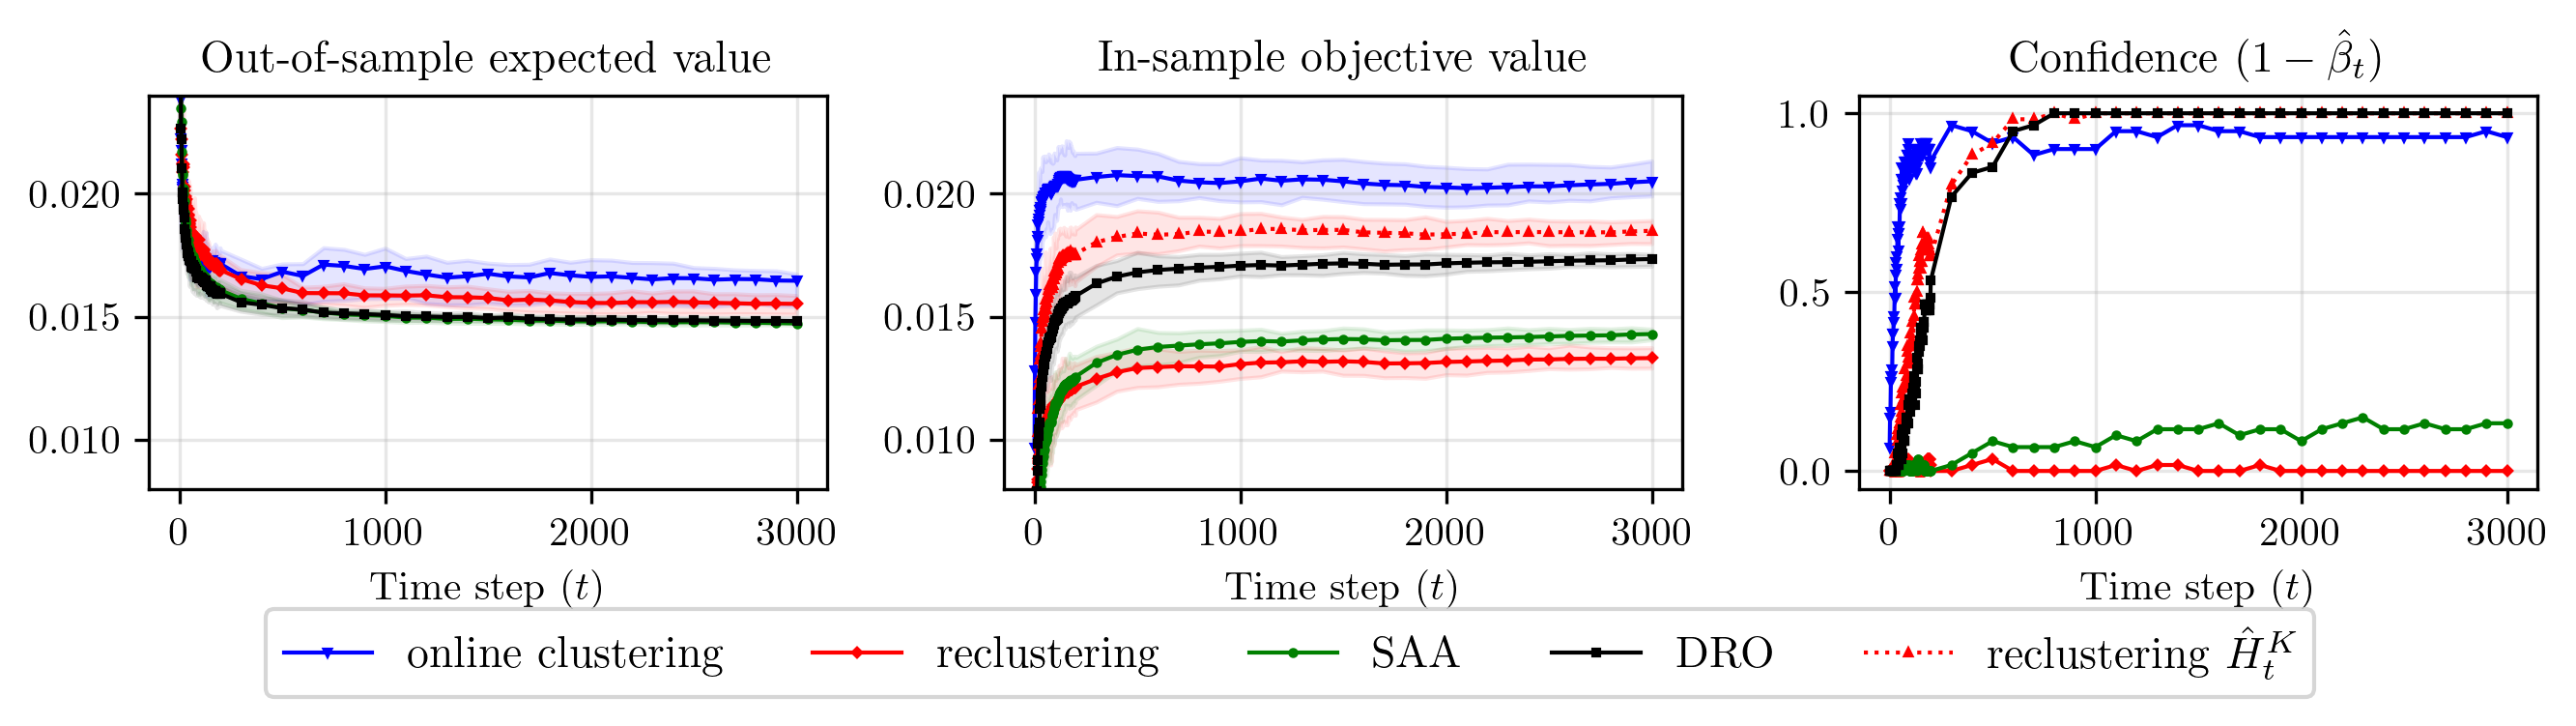

In [195]:
K = 15
# plot_eval_all(df,quantiles,df[0],quantiles[0],j=(0,8,2),K=5,q=(25,75),ylim=[0.008,0.024],legend = False,val2=2.3,end_ind=257)

plot_eval_all(df,quantiles,df[0],quantiles[0],j=(1,8,2),K=15,q=(25,75),ylim=[0.008,0.024],legend = True,val2=2.3,end_ind = 257)

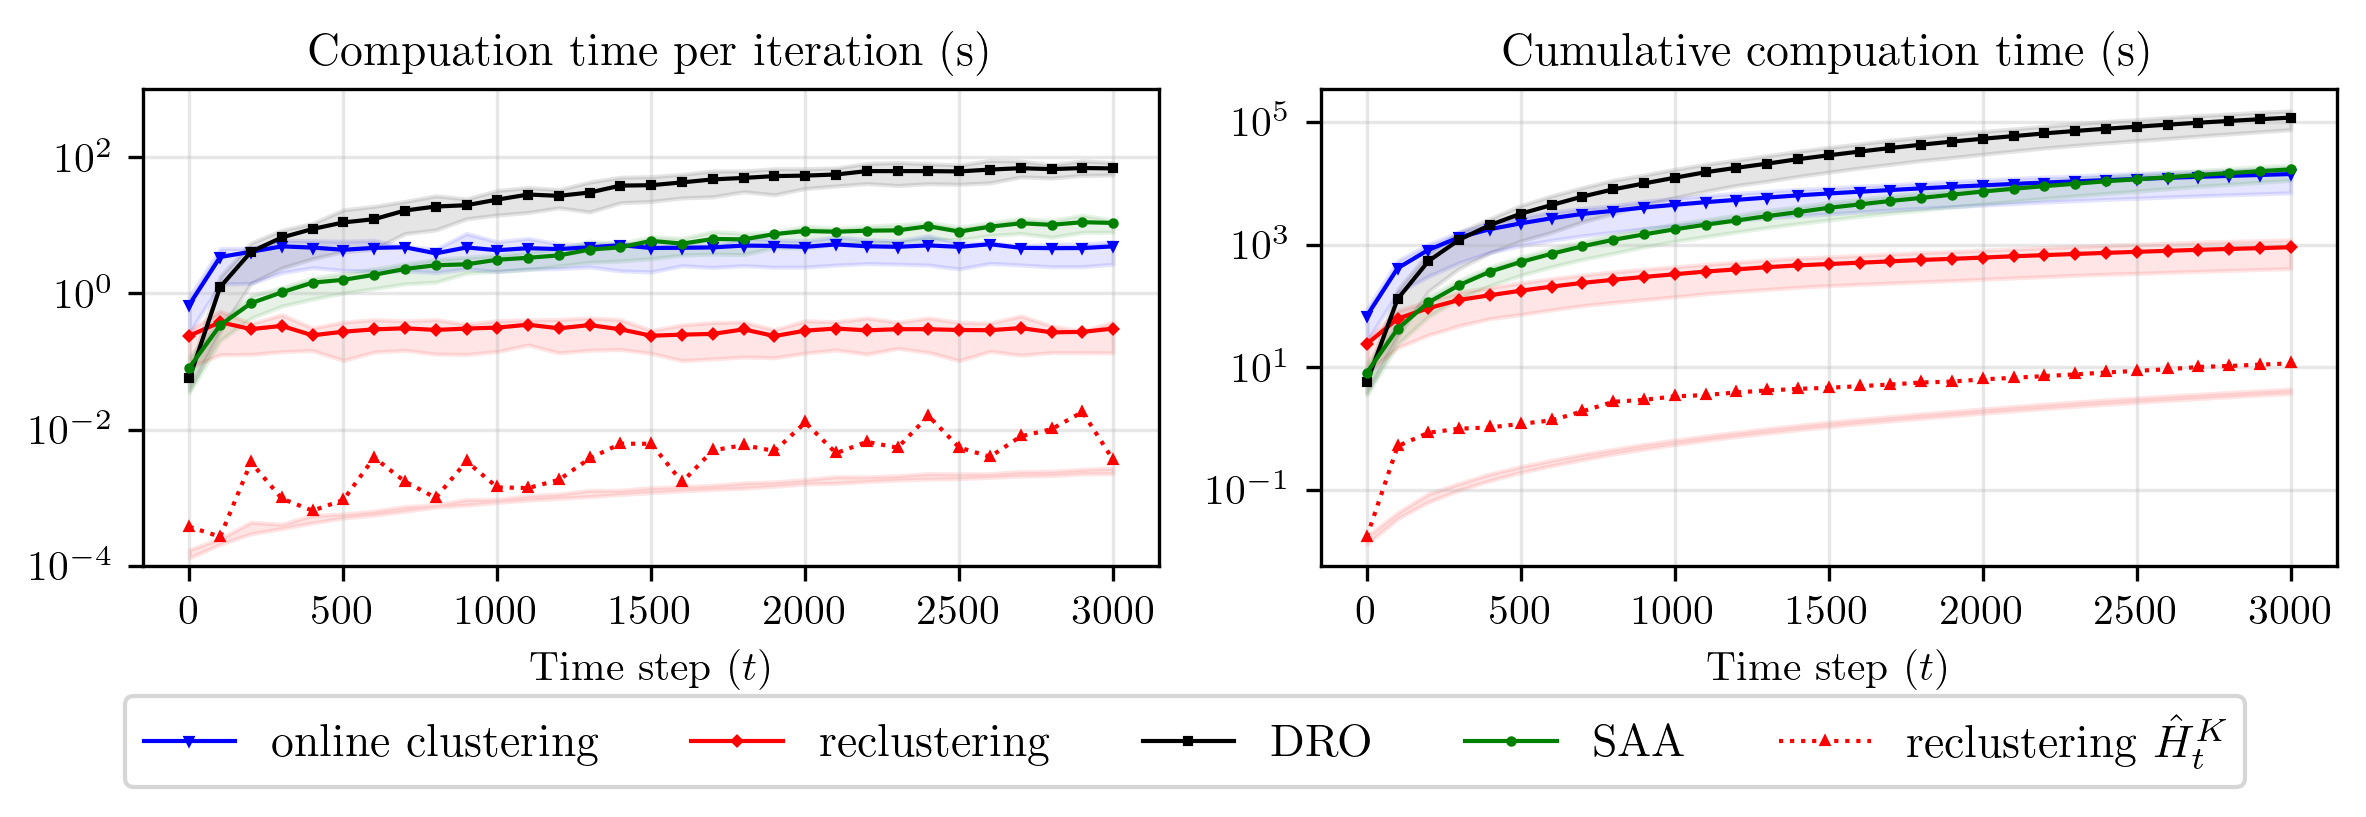

In [152]:
plot_computation_times(df,quantiles,df[0],quantiles[0],j=(3,8,2),K=15,q=(25,75),end_ind = 257)

(30,)


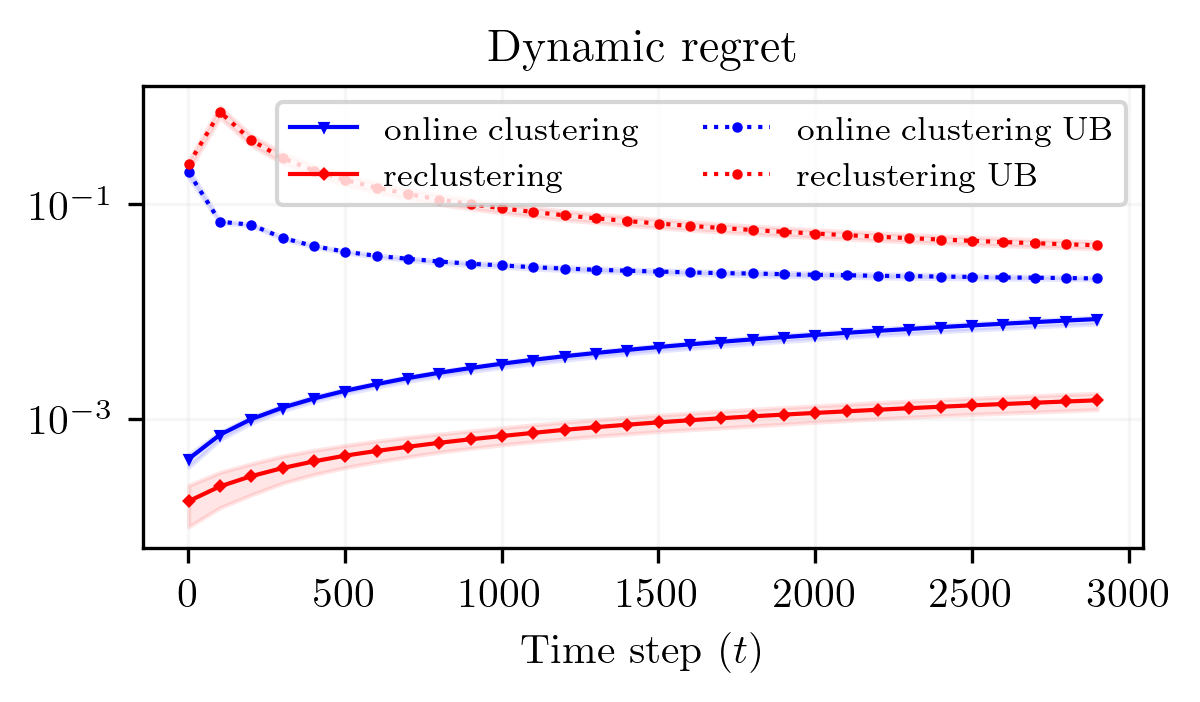

In [179]:
plot_regret(df,quantiles,df[0],quantiles[0],j=(3,8,2),K=15,q=(25,75),end_ind = 257)


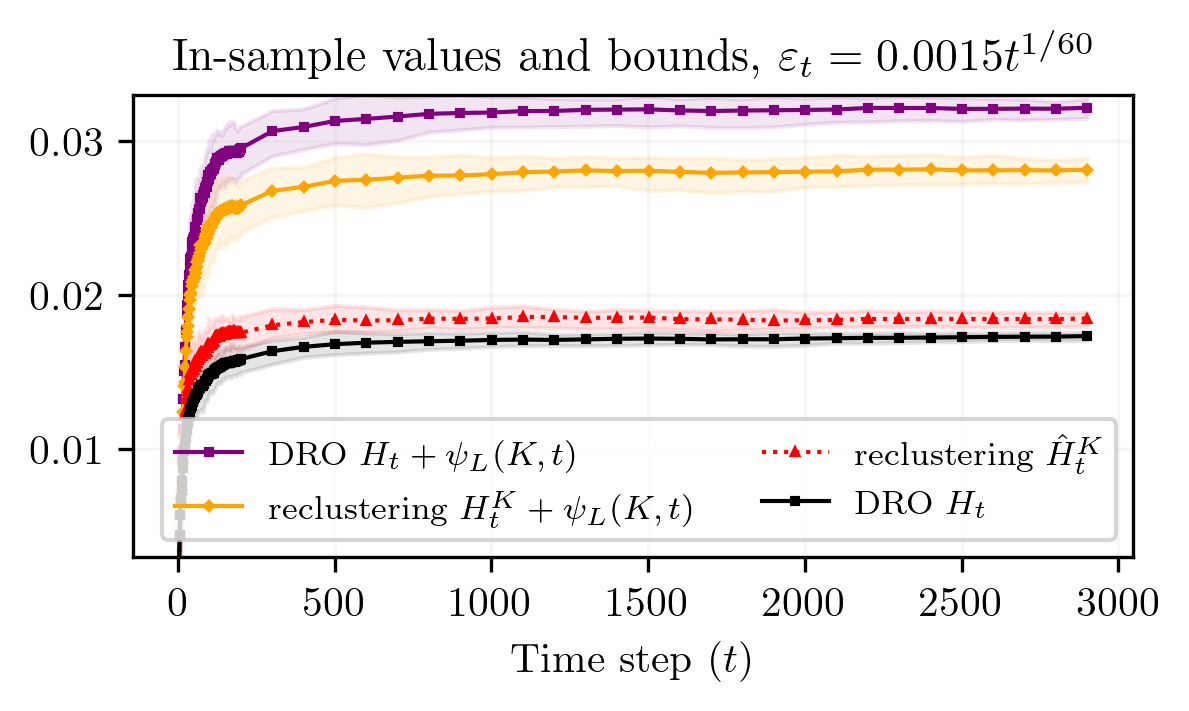

In [181]:
plot_bounds(df,quantiles,df[0],quantiles[0],j=(8,8,2),K=K,q=(25,75),end_ind = 257)